In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range
import time
from scipy.special import logsumexp
from scipy.stats import truncnorm
import h5py

import brutus

# plot in-line within the notebook
%matplotlib inline

np.random.seed(300418)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [3]:
# old models
#import h5py
#f = h5py.File('data/grid_v2.h5')
#params = f['parameters'][:]
#models = 10**(-0.4 * f['magnitudes'][:])  # {g, bp, rp, g, r, i, z, y, J, H, Ks, W1, W2} flux
#models = models[np.isnan(models).sum(axis=1) == 0]
#models_err, models_mask = np.zeros_like(models), np.ones_like(models)
#Nmodels, Nbands = models.shape

In [4]:
# new models
from brutus import seds
filters = seds.gaia + seds.ps + seds.tmass + seds.wise[:2]
f = h5py.File('data/grid_v3.h5')
params = f['parameters'][:]
labels = f['labels'][:]
models = np.zeros((len(labels), len(filters)), dtype='float32')
mags = f['magnitudes']
for i, filt in enumerate(filters):
    sys.stderr.write('\rReading filter {}              '.format(filt))
    models[:, i] = 10.**(-0.4 * mags[filt])
models_err, models_mask = np.zeros_like(models), np.ones_like(models)
Nmodels, Nbands = models.shape

# Apply zeropoint correction to match old mocks
models[:, :3] *= 10**(-0.4 * np.array([-0.02496, -0.02961, -0.01644]))

Reading filter WISE_W2                     

In [5]:
# load in data
from astropy.table import Table
from frankenz.pdf import inv_magnitude
t = Table.read('data/brutus_testing[phot_w_errs]v3.csv', format='csv')
mag_true = np.array([t['Gaia_G_DR2Rev'], t['Gaia_BP_DR2Rev'], t['Gaia_RP_DR2Rev'],
                     t['PS_g'], t['PS_r'], t['PS_i'], t['PS_z'], t['PS_y'],
                     t['2MASS_J'], t['2MASS_H'], t['2MASS_Ks'], 
                     t['WISE_W1'], t['WISE_W2']]).T
magerr = np.array([t['Gaia_G_DR2Rev_sig'], t['Gaia_BP_DR2Rev_sig'], t['Gaia_RP_DR2Rev_sig'],
                   t['PS_g_sig'], t['PS_r_sig'], t['PS_i_sig'], t['PS_z_sig'], t['PS_y_sig'],
                   t['2MASS_J_sig'], t['2MASS_H_sig'], t['2MASS_Ks_sig'], 
                   t['WISE_W1_sig'], t['WISE_W2_sig']]).T
parallax_true, parallax_err = np.array(t['parallax']), np.array(t['parallax_error'])
phot_true, err_true = inv_magnitude(mag_true, magerr)
mask = np.ones_like(err_true)
err = np.sqrt(err_true**2 + (0.02 * phot_true)**2)
phot = np.random.normal(phot_true, err)  # add noise
parallax = np.random.normal(parallax_true, parallax_err)  # add noise
Nobjs = len(parallax)

In [6]:
# load in results (no gaia)
f = h5py.File('data/mock_brutus_v3_nogaia.h5')
s_ng = f['scales'][:]
se_ng = f['scales_err'][:]
idxs_ng = f['idxs'][:]
chi2_ng = f['best_chi2'][:]
levid_ng = f['log_evidence'][:]

# load in results (w/ gaia)
f = h5py.File('data/mock_brutus_v3_yesgaia.h5')
s_yg = f['scales'][:]
se_yg = f['scales_err'][:]
idxs_yg = f['idxs'][:]
chi2_yg = f['best_chi2'][:]
levid_yg = f['log_evidence'][:]

In [7]:
# combine labels
lnames = np.append(labels.dtype.names, params.dtype.names[:-1])  # remove agewts
combined_params = np.zeros(Nmodels, dtype=np.dtype([(n, np.float) for n in lnames]))
for n in labels.dtype.names:
    combined_params[n] = labels[n]
for n in params.dtype.names[:-1]:
    combined_params[n] = params[n]

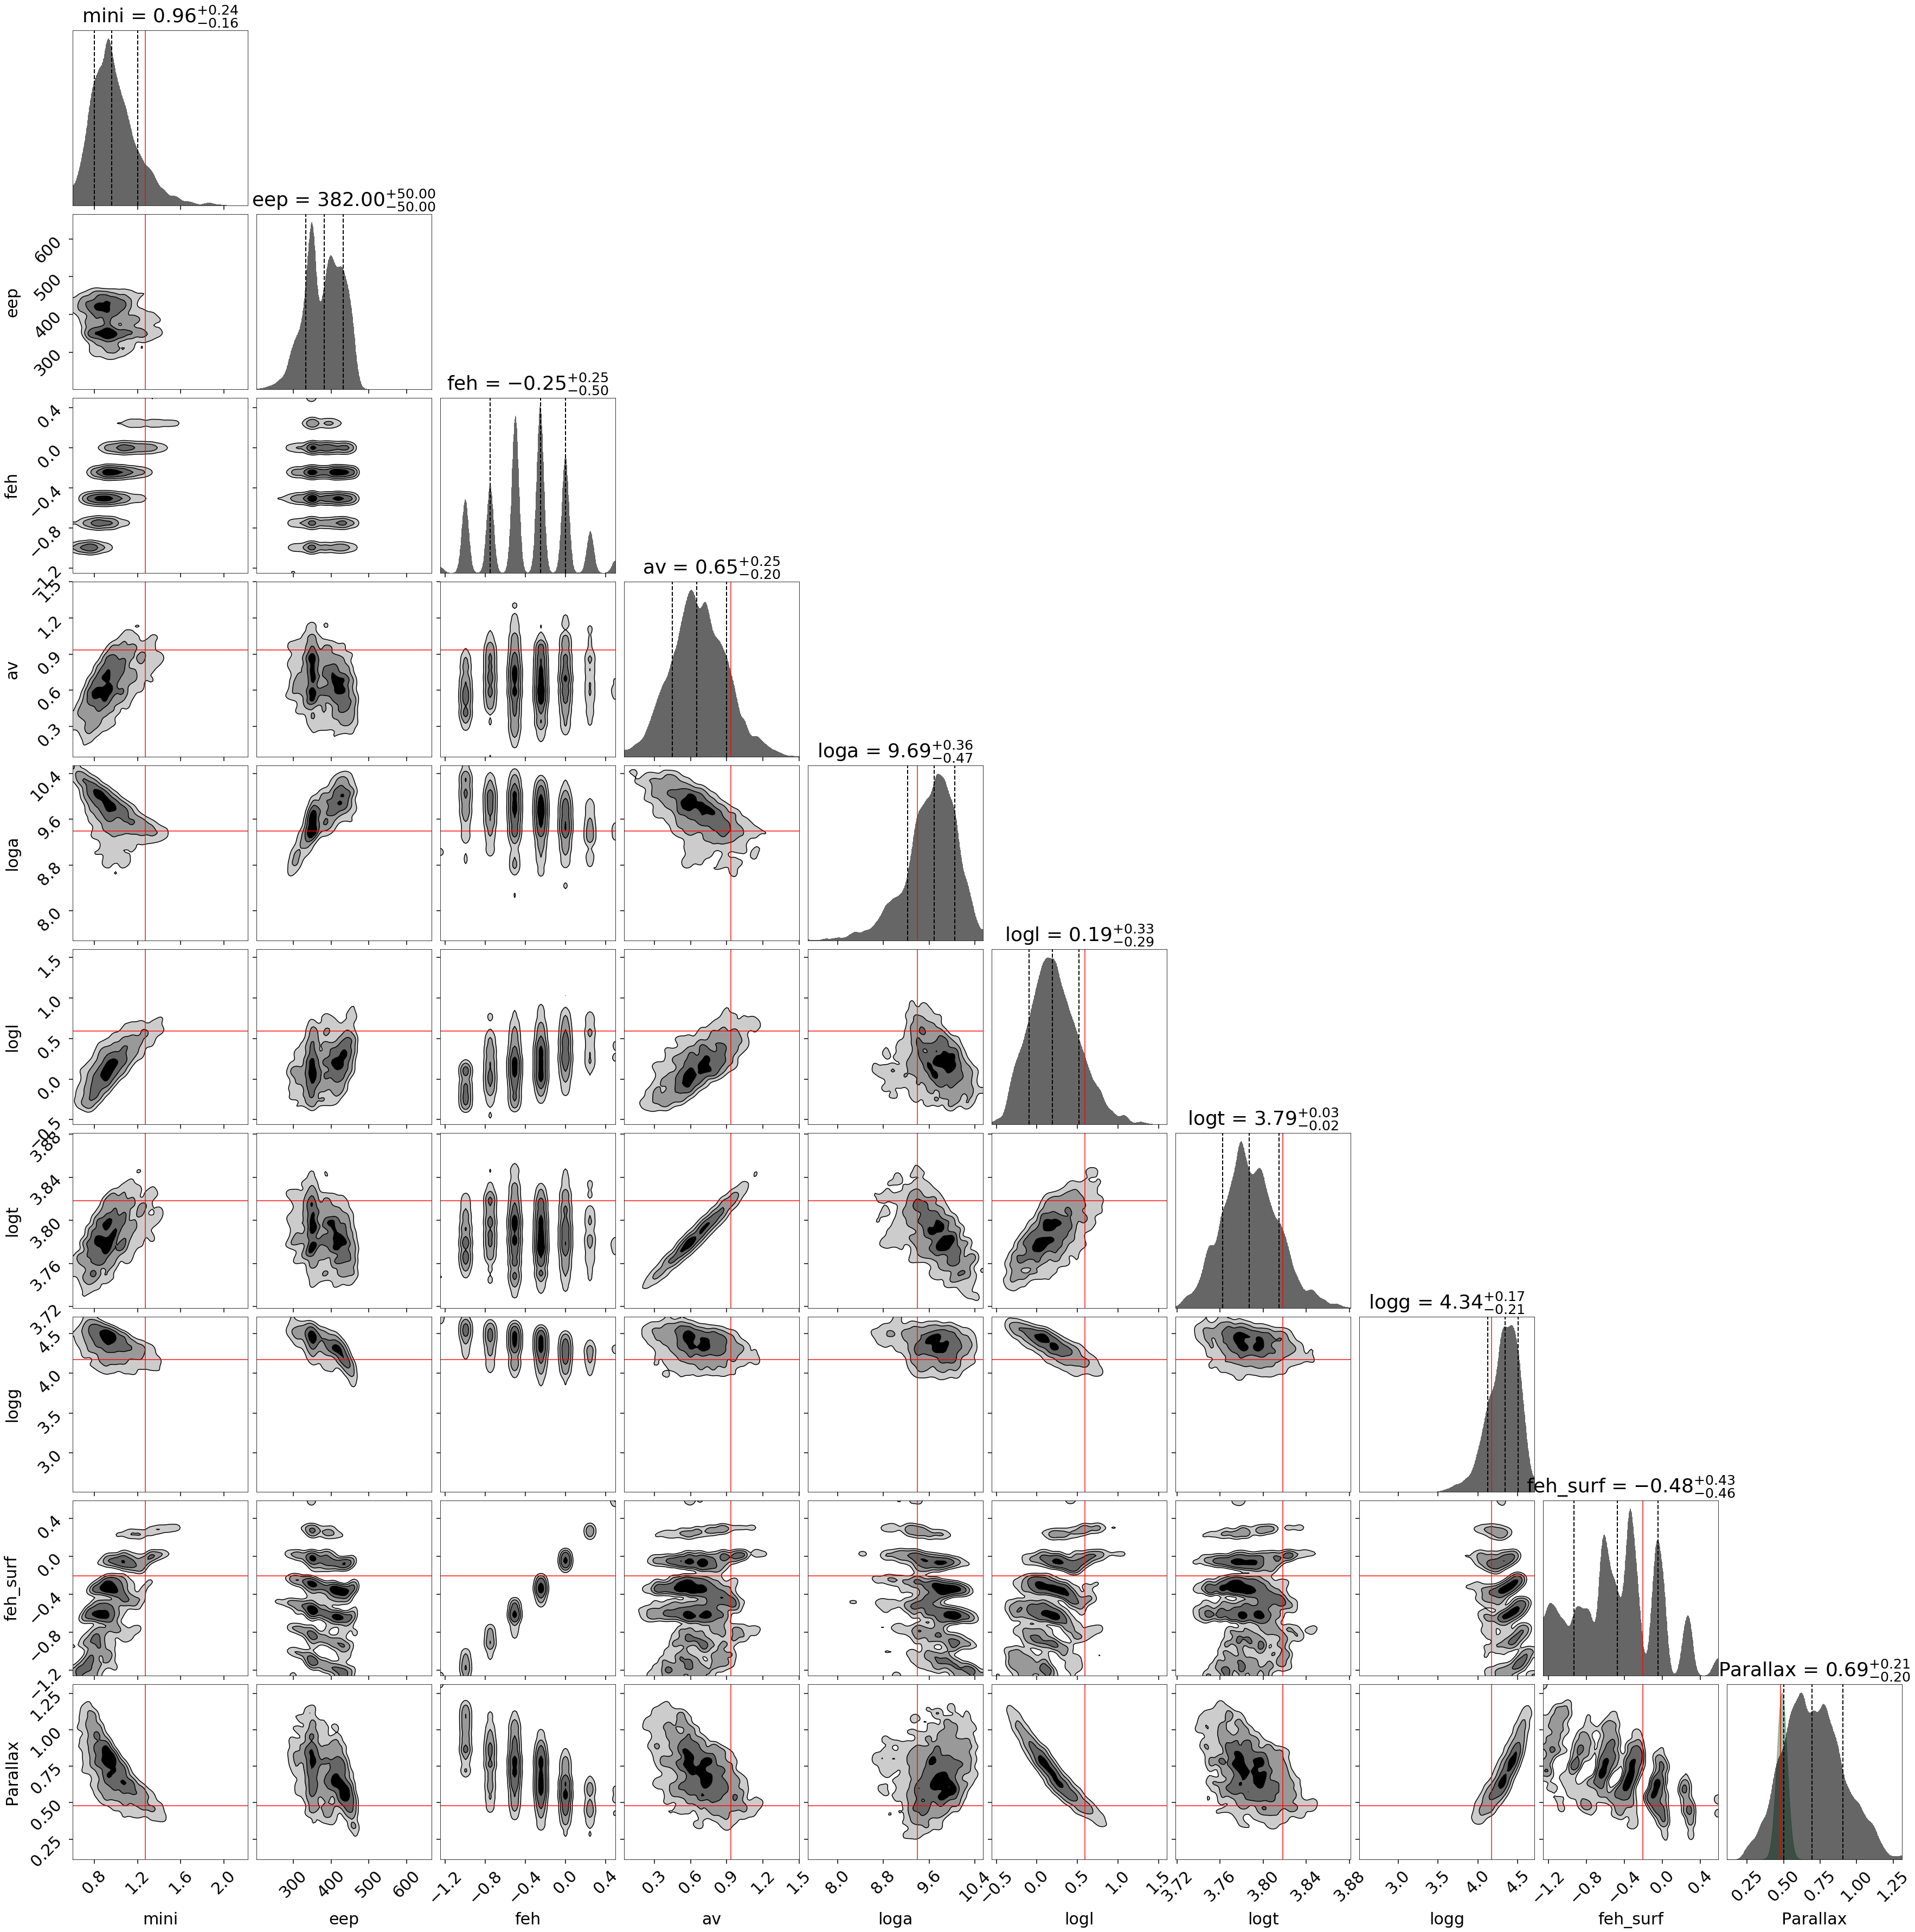

In [8]:
# plot results
from brutus import plotting as bplot

i = 22
truth = (t['mass'][i], None, None, t['a0'][i], np.log10(t['age'][i]) + 9, 
         np.log10(t['lum'][i]), np.log10(t['teff'][i]), t['logg'][i], t['feh'][i],
         t['parallax'][i])

# without gaia
fig, axes = bplot.cornerplot(idxs_ng[i], s_ng[i], se_ng[i], combined_params,
                             truths=truth, 
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=False, pcolor='seagreen',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))

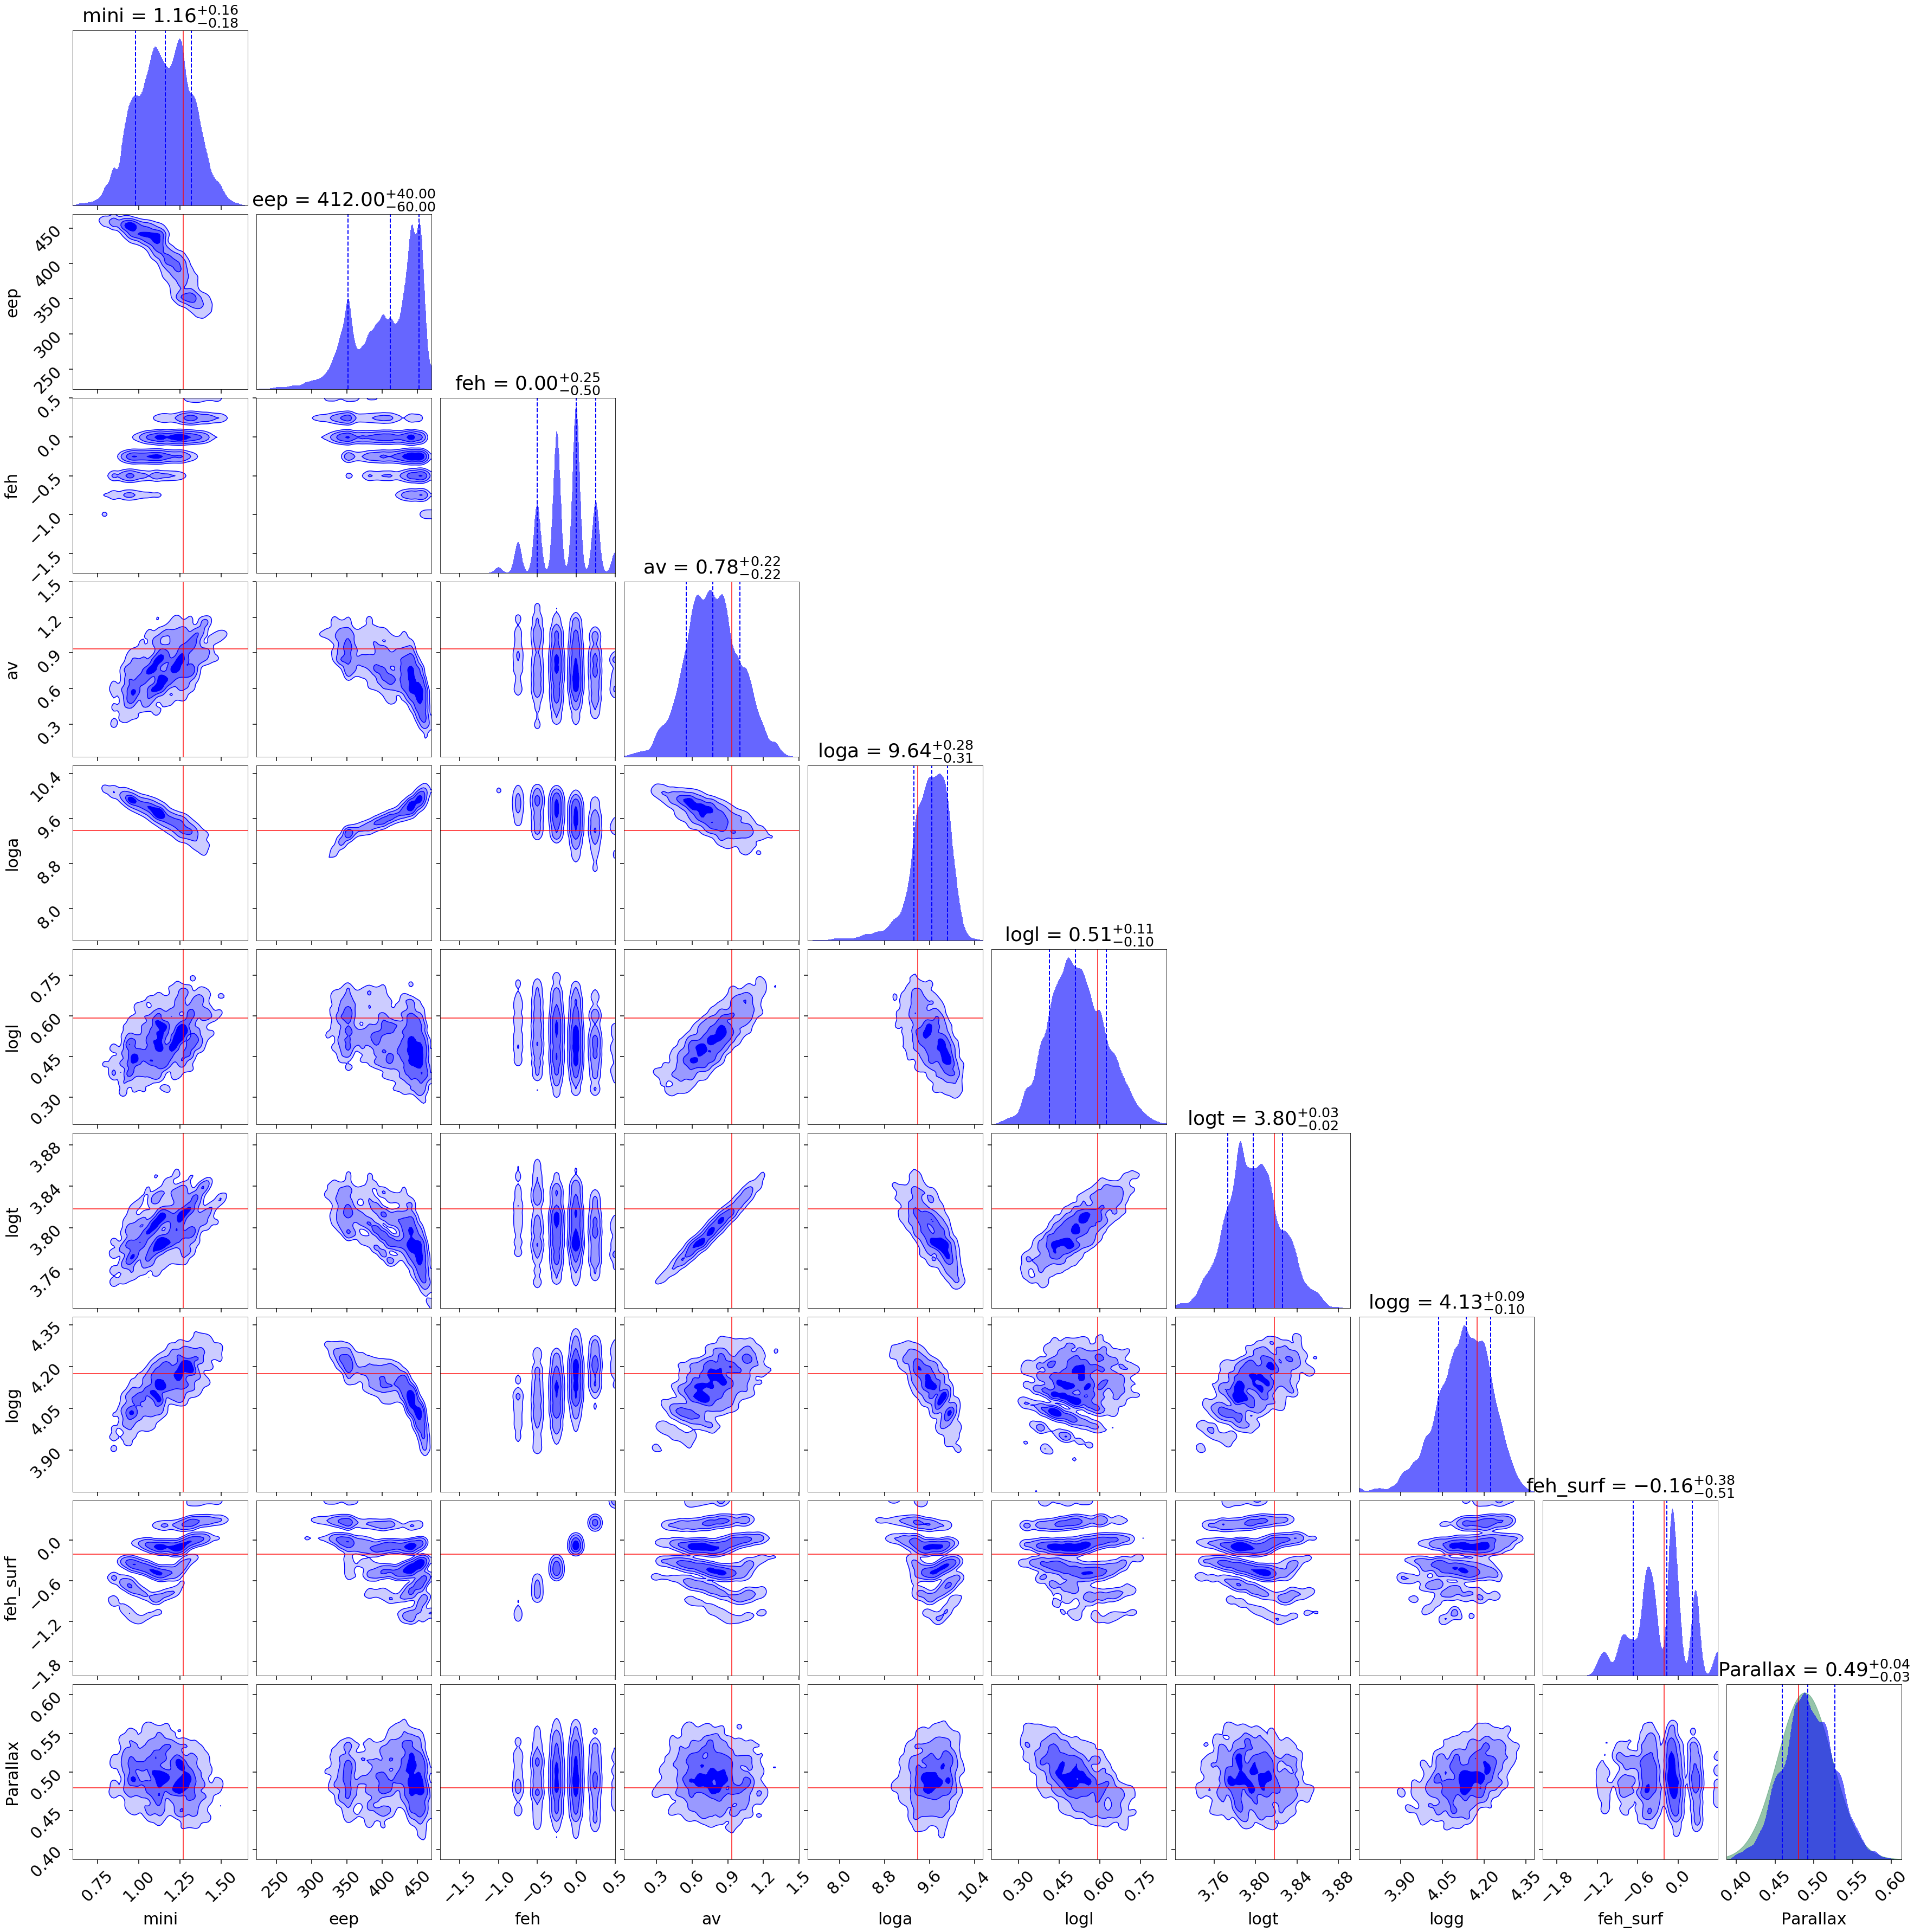

In [9]:
# with gaia
fig, axes = bplot.cornerplot(idxs_yg[i], s_yg[i], se_yg[i], combined_params,
                             truths=truth, color='blue',
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             applied_parallax=True, pcolor='seagreen',
                             show_titles=True, title_kwargs={'y': 1.03},
                             fig=plt.subplots(10, 10, figsize=(50, 50)))